In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install nltk
!pip install matplotlib
!pip install seaborn
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

### FP with ceiling = 15

In [ ]:
all_predictions = pd.read_csv('all_predictions_250124_15_ceiling.csv')
all_predictions.head()

,filename,true_class,predicted_class,feature_set,iteration
0,1887_SkramA_SjurGabrielHellemyrsfolket,CANON,O,embeddings,1
1,1875_Vende_LeonieEllerEnNatIMinerne_2,O,O,embeddings,1
2,1877_Drachmann_Tannhauser,CANON,CANON,embeddings,1
3,1898_Anonym_KampForFriheden,O,O,embeddings,1
4,1889_Birck_AageEllerEbbe,O,O,embeddings,1


In [ ]:
all_predictions.groupby('filename')['filename'].count().sort_values().head(40)

filename
1884_Schjoerring_EsthersHistorie                        144
1874_Brandis_GamleJomfruTraegaardsErindringer           144
1871_Behrend_Madelaine                                  156
1893_LevetzowC_NyeDage                                  156
1872_Gioerup_GadenOgHjemmetEllerTaterlivIKjoebenhavn    156
1876_Hjelm_OerkenensSlange_2                            156
1888_Trafall_KjaempendeMagter                           168
1888_Solter_Forlovelser                                 168
1877_Paulsen_Dorothea                                   168
1882_JacobsenA_EnJournalist                             168
1878_HenningsenE_MathildeOgHendesVenner                 168
1893_OestergaardV_NielsRibesAeventyr                    180
1893_Schoeyen_EtLoefte                                  180
1893_Schjoerring_SkiftendeTider                         180
1893_Houlberg_Aspiranter                                180
1893_JoergensenJ_LivetsTrae                             180
1893_KragT_Mulm                

In [ ]:
all_predictions[all_predictions['filename'] == '1884_Schjoerring_EsthersHistorie'].groupby('feature_set')['feature_set'].count()

feature_set
avg_sentence_length           12
embeddings                    12
embeddings_price              12
embeddings_publisher          12
embeddings_publisher_price    12
nationality                   12
price                         12
published_gender              12
publisher                     12
publisher_nationality         12
publisher_price               12
real_gender                   12
Name: feature_set, dtype: int64

In [ ]:
all_predictions['feature_set'].nunique()

12

In [ ]:
# Filter the df so every book has the same number of predictions (lower bound is 12, see the groupby above)

filtered_df = (
    all_predictions.groupby(["filename", "feature_set"], group_keys=False)
    .apply(lambda group: group.head(12))
)

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_30081/2117989703.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_predictions.groupby(["filename", "feature_set"], group_keys=False)


In [ ]:
# Filter rows where feature_set is 'embeddings', true_class is 'O', and predicted_class is 'CANON'
embeddings_condition = (
    (filtered_df["feature_set"] == "embeddings") &
    (filtered_df["true_class"] == "O") &
    (filtered_df["predicted_class"] == "CANON")
)

# Extract unique filenames that meet the condition
filenames_list = filtered_df.loc[embeddings_condition, "filename"].unique()


In [ ]:
len(filenames_list)

440

In [ ]:
# Filter rows in filtered_df where the filename appears in filenames_list
rows_with_fp_filenames = filtered_df[filtered_df["filename"].isin(filenames_list)]

In [ ]:
rows_with_fp_filenames.groupby('filename')['filename'].count().sort_values(ascending=False)

filename
1870_Anonym_KraemmersvendeOgSyjomfruerEllerPrincipalernesPengeskuffer    144
1895_IbsenA_SoesterHelene                                                144
1895_MoellerC_EfterLevendeModel                                          144
1895_Michaelis_Aebeloe                                                   144
1895_Mariager_Sparta                                                     144
                                                                        ... 
1887_Schjoerring_ForVindOgVove                                           144
1887_Paulsen_EnFremtidskvinde                                            144
1887_Muusmann_ForfloejnePile                                             144
1887_LieJ_EtSamliv                                                       144
1899_Wied_LivsensOndskab                                                 144
Name: filename, Length: 440, dtype: int64

In [ ]:
# Calculate match percentage
rows_with_fp_filenames['match'] = (rows_with_fp_filenames['true_class'] != rows_with_fp_filenames['predicted_class']).astype(int)

# Group by filename and feature_set to calculate percentage of matches
percentages = (
    rows_with_fp_filenames.groupby(['filename', 'feature_set'])['match']
    .mean()
    .reset_index()
    .rename(columns={'match': 'match_percentage'})
)

# Calculate the total count of occurrences for each filename
filename_counts = (
    rows_with_fp_filenames.groupby('filename')
    .size()
    .reset_index(name='count')
)

# Merge the counts into the percentages DataFrame
percentages = percentages.merge(filename_counts, on='filename')

# Pivot to get the desired format
result = percentages.pivot(index='filename', columns='feature_set', values='match_percentage')

# Add the usage count column
result['count'] = (filename_counts.set_index('filename')['count'])/12

# Fill missing values with 0 (if an index does not have entries for a feature_set)
result = result.fillna(0)

/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_30081/3800352411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_fp_filenames['match'] = (rows_with_fp_filenames['true_class'] != rows_with_fp_filenames['predicted_class']).astype(int)


/var/folders/dt/1462j2zd19q_2sh2_66j7_8m6l1brz/T/ipykernel_30081/2093352938.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


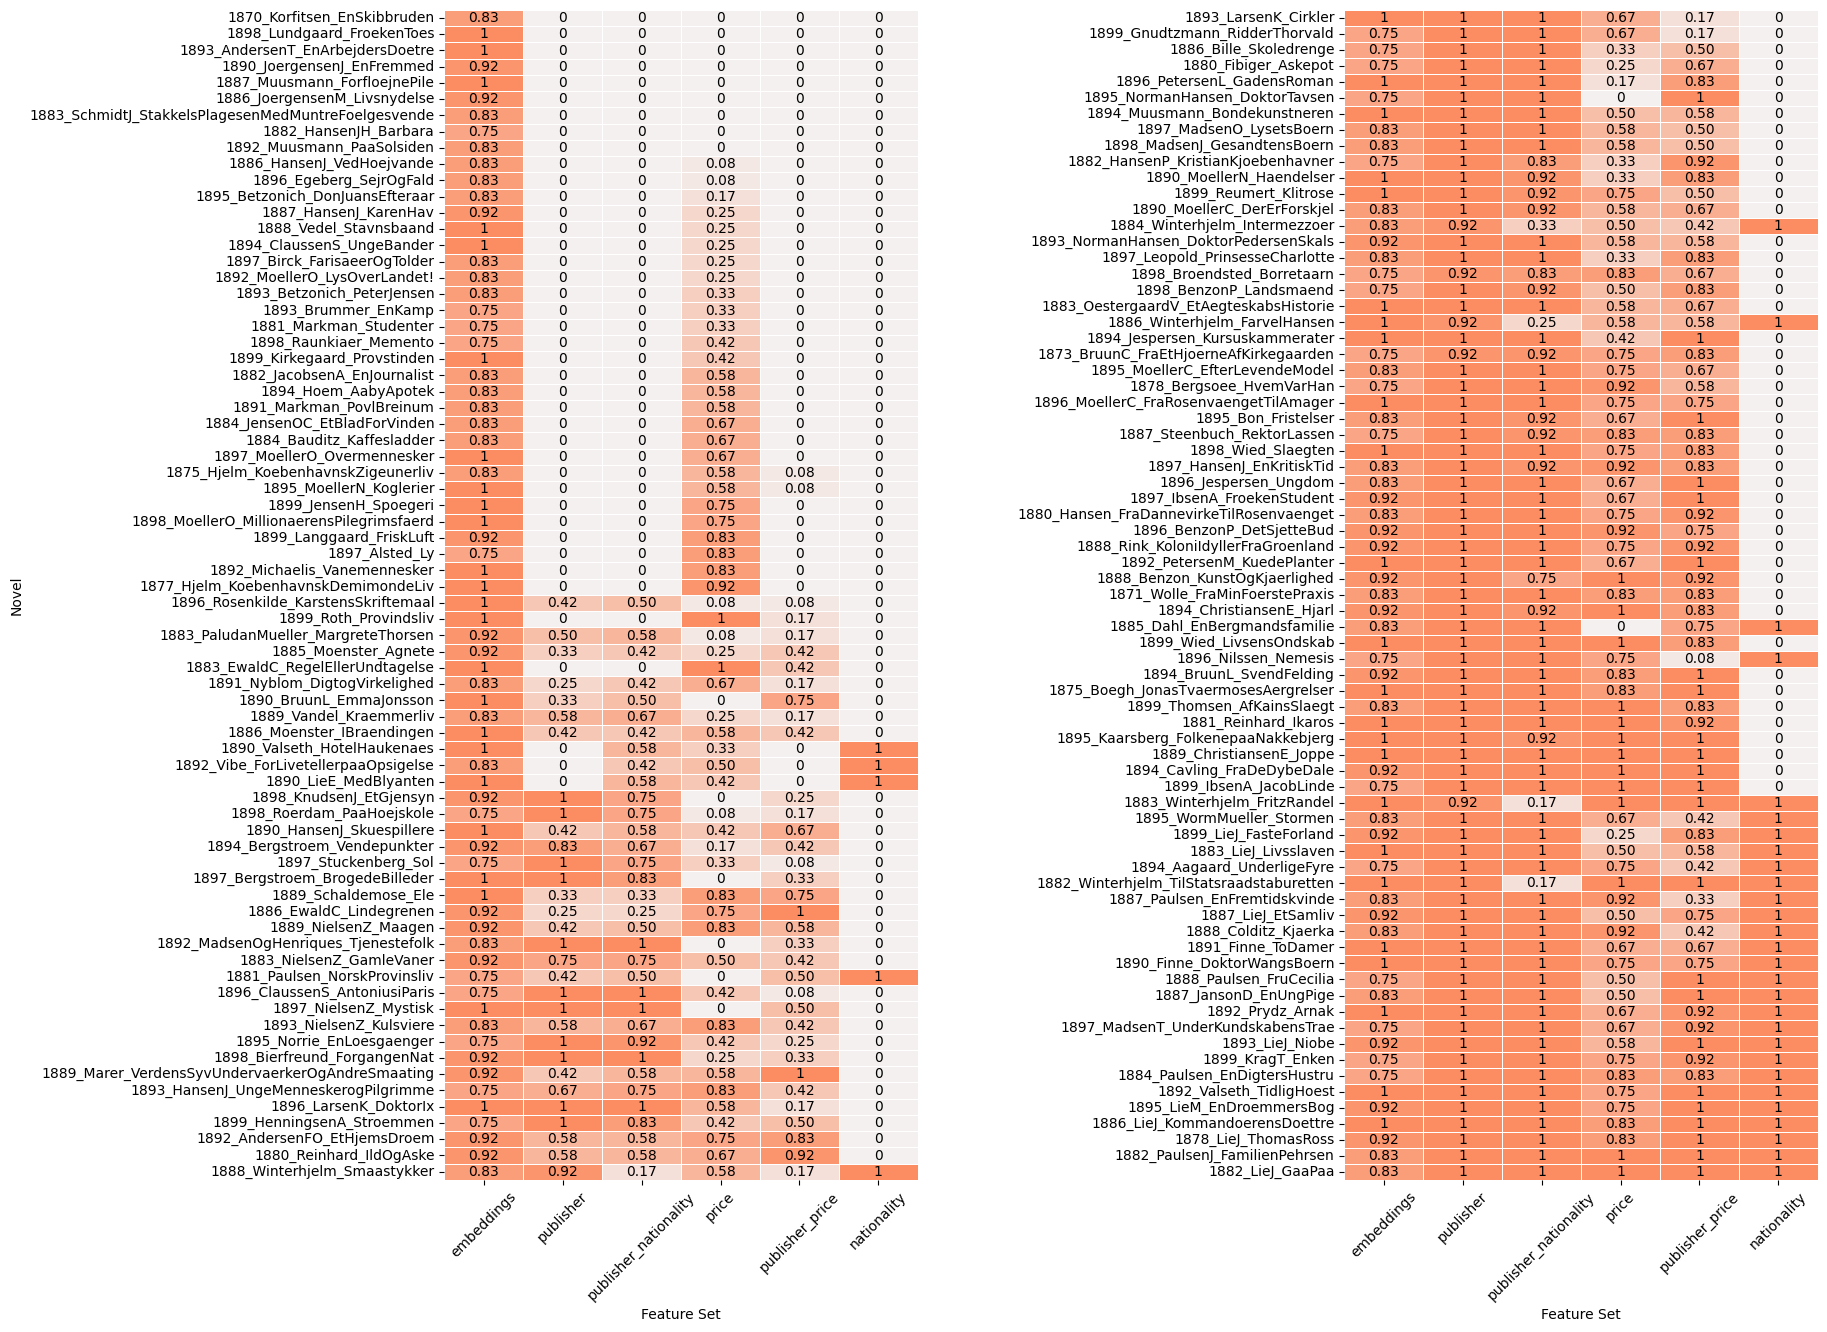

In [ ]:
# Assume `result` DataFrame is provided
heatmap_data = result[['embeddings', 'publisher', 'publisher_nationality', 'price', 'publisher_price', 'nationality']]
heatmap_data = heatmap_data[heatmap_data['embeddings'] > 0.68]

# Calculate the row sums, excluding the 'embeddings' column
row_sums = heatmap_data.drop(columns=['embeddings']).sum(axis=1)

# Sort the DataFrame by the computed row sums in descending order
heatmap_data = heatmap_data.loc[row_sums.sort_values(ascending=True).index]

# Split the DataFrame into two halves
mid_point = len(heatmap_data) // 2
heatmap_left = heatmap_data.iloc[:mid_point]
heatmap_right = heatmap_data.iloc[mid_point:]

# Determine the common color range
vmin = heatmap_data.min().min()
vmax = heatmap_data.max().max()

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 15), constrained_layout=True)

# Left heatmap
sns.heatmap(
    heatmap_left,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=0.5,
    cbar=False,
    ax=axes[0],
    vmin=vmin,
    vmax=vmax,
    yticklabels=heatmap_left.index
)
axes[0].set_ylabel("Novel")
axes[0].set_xlabel("Feature Set")

# Right heatmap
sns.heatmap(
    heatmap_right,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=0.5,
    cbar=False,
    ax=axes[1],
    vmin=vmin,
    vmax=vmax,
    yticklabels=heatmap_right.index
)
axes[1].set_ylabel("")
axes[1].set_xlabel("Feature Set")

# Customize annotations for both heatmaps
for ax, data in zip(axes, [heatmap_left, heatmap_right]):
    for text, (i, j) in zip(ax.texts, np.ndindex(data.shape)):
        text.set_color('black')
        value = float(text.get_text())
        if value.is_integer():
            text.set_text(f"{int(value)}")

# Adjust tick labels
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

#plt.suptitle("Heatmap Split into Two Columns", fontsize=16)
plt.tight_layout()
plt.savefig('figs/heatmap_split_fp_ceiling_sorted.pdf', bbox_inches='tight')
plt.show()

In [ ]:
heatmap_data.head()

feature_set,embeddings,publisher,publisher_nationality,price,publisher_price,nationality
filename,,,,,,
1870_Korfitsen_EnSkibbruden,0.833333,0.0,0.0,0.0,0.0,0.0
1898_Lundgaard_FroekenToes,1.000000,0.0,0.0,0.0,0.0,0.0
1893_AndersenT_EnArbejdersDoetre,1.000000,0.0,0.0,0.0,0.0,0.0
1890_JoergensenJ_EnFremmed,0.916667,0.0,0.0,0.0,0.0,0.0
1887_Muusmann_ForfloejnePile,1.000000,0.0,0.0,0.0,0.0,0.0


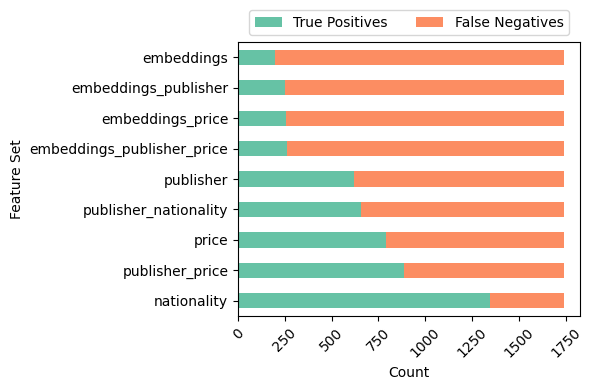

In [ ]:
exclude_feature_sets = ["avg_sentence_length", "real_gender", "published_gender"]

# Exclude rows with any feature_set in the exclude_feature_sets list
rows_filtered = rows_with_fp_filenames[~rows_with_fp_filenames["feature_set"].isin(exclude_feature_sets)]

rows_filtered = rows_filtered[rows_filtered['filename'].isin(heatmap_data.index)]

# Group by feature_set and calculate counts of 0s and 1s
stacked_data = (
    rows_filtered.groupby(['feature_set', 'match'])
    .size()
    .unstack(fill_value=0)
)

# Get the first two colors from the Set2 color palette
colors = sns.color_palette("Set2", 2)

# Sort the stacked data by the count of true positives (match = 0)
stacked_data_sorted = stacked_data.sort_values(by=0, ascending=False)

# Plot stacked bar chart with specified colors
stacked_data_sorted.plot(kind='barh', stacked=True, figsize=(6,4), color=colors)
#plt.title("True and false predictions of FPs with embeddings")
plt.xlabel('Count')
plt.ylabel('Feature Set')
plt.legend(labels=['True Positives', 'False Negatives'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.savefig('figs/true_false_per_set_ceiling.pdf', bbox_inches='tight')

In [ ]:
fps_meta = heatmap_data.merge(df, left_on='filename', right_on='filename')

In [ ]:
fps_meta.groupby('publisher_y')['publisher_y'].count().sort_values(ascending=False)

publisher_y
Gyldendal                        54
Schubothe                        14
Schou                            11
Det Nordiske Forlag               9
Reitzel                           7
Gad                               5
Cammermeyer                       5
Jydsk Forlags-forretning          5
Jens Møller                       3
Mansa                             3
V. Pio                            3
Bergmann                          2
Erslev                            2
Kihl & Langkiær                   2
Eibe                              2
Philipsen                         2
Gjellerup                         1
Prior                             1
Bjørn Bjarnasons Forlag           1
S. Brodersen                      1
S. Birck                          1
Rom                               1
Chr. Steen & Søn                  1
P. Olsen                          1
Philipsen                         1
Forfatteren                       1
Joh. Møller                       1
A. Christiansen 

In [ ]:
fps_meta['publisher_y'].nunique()

32

In [ ]:
fps_meta.head()

,filename,embeddings,publisher_x,publisher_nationality,price_x,publisher_price,nationality_x,full_firstnames,auth_first,auth_last_modern,...,period,period_notes,novel_start,novel_end,serialno,category,e_canon,ce_canon,lex_canon,text
0,1870_Korfitsen_EnSkibbruden,0.833333,0.0,0.0,0.0,0.0,0.0,Valdemar,Valdemar,Korfitsen,...,nan,nan,9.0,113.0,407.0,O,0,0,0,I. Et gilde. „ Mine herrer! — „ Min herre! “ u...
1,1898_Lundgaard_FroekenToes,1.000000,0.0,0.0,0.0,0.0,0.0,Christian,Christian,Lundgård,...,nan,nan,9.0,139.0,489.0,O,0,0,0,"Første kapitel i Dannebrogsgade ligger der, me..."
2,1893_AndersenT_EnArbejdersDoetre,1.000000,0.0,0.0,0.0,0.0,0.0,Theodor,Theodor,Andersen,...,nan,nan,13.0,280.0,17.0,O,0,0,0,"I. Bryllupsgildet. » Å, vær så god at gå til b..."
3,1890_JoergensenJ_EnFremmed,0.916667,0.0,0.0,0.0,0.0,0.0,Johannes,Johannes,Jørgensen,...,nan,nan,11.0,166.0,368.0,O,0,0,0,I. Anders sad på en bænk i Frederiksberg have....
4,1887_Muusmann_ForfloejnePile,1.000000,0.0,0.0,0.0,0.0,0.0,Carl,Carl,Muusmann,...,nan,nan,15.0,128.0,536.0,O,0,0,0,Da mine såler kun var et hul og blækhuset mit ...


In [ ]:
fps_meta.groupby('nationality_y')['nationality_y'].count()

nationality_y
dk    112
no     33
Name: nationality_y, dtype: int64